## Lab #5: Deep learning for genomics
Friday, May 3rd

Name: Matt Ploenzke

### CNN training
#### Problem formulation

The popularity of deep learning methods for genomic applications has grown impressively over the past few years. While not quite to the level of computer vision, both computational methods and user APIs have been developed specifically for the application to DNA (and protein) sequence data. Recall in such cases each input observation is a string of nucleotides (or amino acids in the protein example). Although it is indeed interesting to incorporate additional streams of data, we will restrict ourselves to only using the nucleotide sequence and then use CNNs to learn about the sequences. 

Specifically, we will be using a simulated dataset to investigate a common use scenario which may arise from ChIP-seq experiments. The goal of a [ChIP-seq](https://en.wikipedia.org/wiki/ChIP-sequencing) experiment is to use DNA sequencing to identify DNA-binding sites of proteins/transcription factors (TFs) along the genome. These proteins have varying effects on the genome, such as promoting or suppressing gene expression or even determining how the genome is folded and thus which parts are accessible to transcription. The downstream consequences of differential binding due to these proteins across healthy and diseased individuals is an active area of research. All simulations were generated via the [learning sequence motifs](https://github.com/p-koo/learning_sequence_motifs) package.

The details of the protocol are not important for this assignment. All you really need to know  is that each protein is relatively small (on the order of 6-18 base pairs in length) and exhibits preferential binding to certain consensus sequences. You may think of a single protein/TF somewhat like a lock and key: the protein preferentially binds (attaches) to the genome at locations where the pattern matches. ChIP is then used to locate those areas and DNA high-throughput sequencing yields the nucleotide sequences which were attached to the protein and for which we may then use as our input data. 

The consensus sequence that each protein looks for is referred to as a motif. Nine motifs are included in the simulation dataset and are provided below for reference. Conceptually, for a given motif pictured below, you may think of the height of the letter at a given position as the specificity of the protein binding to that nucleotide. For example, for the Arid3a motif, the protein would almost exclusively bind to the pattern **AT_AA_** where the first underscore is either a T or a C with equal probability, and the last position is either an A or T. ![Embedded motifs](img/lab_5_motifs.png)

We will consider the case in which our collaborators have performed three different ChIP-seq experiments, each time *ChIP-ing* for a different protein (i.e. one of each protein from above), and provided us with a data file containing 200bp-length sequences called from each experiment. These are referred to as ChIP-seq peaks. For example, for the Arid3a ChIP-seq experiment, the sequences called will contain the Arid3a motif at some location within the 200 base-pairs. The actual nucleotide sequence of the realized motif in a given sequence will likely contain **AT_AA_** where the first underscore is either a T or a C with equal probability and the last position is either an A or T (note how this relates to above!). Additionally, a single peak may have been called in multiple experiments (Hint: class labels are not exclusive, consider how this will affect your loss function). Several example sequences are provided below, with the embedded motif visualized at its respective location within the observation. All other locations along the sequence are random genome background. Ideally our model will be able to learn these patterns.
![Example sequences](img/lab_5_grammers.png)

All reads (the nucleotide sequences) for the training, testing, and validation data have been joined in one file and the associated labels are provided as well. All data are stored in the lab_5_dataset.h5 object available on the canvas site. We will be training a CNN using the nucleotide sequences as input and the protein ChIP-ed for as the output label. We will then investigate what our model has learned. 

#### Train a CNN on simulation data

Load the libraries.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os, sys
import numpy as np
import matplotlib.pyplot as plt
import keras
import h5py

Using TensorFlow backend.


Load the data. Note that we will not be using a data generator as we have in the past for image data. Therefore we may simply load each as a numpy array and then join them into a single dictionary. Each observation is already one-hot encoded.

In [2]:
# load dataset
data_path = 'data/lab_5_dataset.h5'
trainmat = h5py.File(data_path, 'r')

print("loading training data")
X_train = np.array(trainmat['X_train']).astype(np.float32)
y_train = np.array(trainmat['Y_train']).astype(np.float32)

print("loading cross-validation data")
X_valid = np.array(trainmat['X_valid']).astype(np.float32)
y_valid = np.array(trainmat['Y_valid']).astype(np.int32)

print("loading test data")
X_test = np.array(trainmat['X_test']).astype(np.float32)
y_test = np.array(trainmat['Y_test']).astype(np.int32)

loading training data
loading cross-validation data
loading test data


We need to permute the data arrays for keras to accept them. 

In [3]:
X_train = np.expand_dims(X_train, axis=3).transpose([0,2,3,1])
X_valid = np.expand_dims(X_valid, axis=3).transpose([0,2,3,1])
X_test = np.expand_dims(X_test, axis=3).transpose([0,2,3,1])

train = {'inputs': X_train, 'targets': y_train}
valid = {'inputs': X_valid, 'targets': y_valid}
test = {'inputs': X_test, 'targets': y_test}

How many observations are there in the training set? What is the length of each sequence? What does the last channel (fourth dimension) of a given batch of observation correspond to?

In [4]:
# get data shapes
input_shape = list(train['inputs'].shape)
print(input_shape)
print(train['inputs'][0])

[17500, 200, 1, 4]
[[[0. 0. 0. 1.]]

 [[0. 0. 1. 0.]]

 [[1. 0. 0. 0.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[1. 0. 0. 0.]]

 [[1. 0. 0. 0.]]

 [[0. 0. 1. 0.]]

 [[1. 0. 0. 0.]]

 [[0. 0. 0. 1.]]

 [[1. 0. 0. 0.]]

 [[1. 0. 0. 0.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 1. 0.]]

 [[0. 0. 0. 1.]]

 [[0. 1. 0. 0.]]

 [[1. 0. 0. 0.]]

 [[1. 0. 0. 0.]]

 [[1. 0. 0. 0.]]

 [[0. 0. 1. 0.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 1. 0.]]

 [[1. 0. 0. 0.]]

 [[0. 0. 1. 0.]]

 [[0. 0. 1. 0.]]

 [[0. 1. 0. 0.]]

 [[0. 0. 1. 0.]]

 [[1. 0. 0. 0.]]

 [[1. 0. 0. 0.]]

 [[0. 1. 0. 0.]]

 [[0. 1. 0. 0.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[1. 0. 0. 0.]]

 [[0. 0. 1. 0.]]

 [[0. 1. 0. 0.]]

 [[1. 0. 0. 0.]]

 [[1. 0. 0. 0.]]

 [[1. 0. 0. 0.]]

 [[0. 1. 0. 0.]]

 [[0. 1. 0. 0.]]

 [[0. 0. 1. 0.]]

 [[1. 0. 0. 0.]]

 [[0. 0. 0. 1.]]

 [[1. 0. 0. 0.]]

 [[0. 0. 1. 0.]]

 [[0. 1. 0. 0.]]

 [[0. 0. 0. 1.]]

 [[0. 0. 0. 1.]]

 [[0. 1. 0. 0.]]

 [[1. 0. 0. 0.]]

 [[0. 1. 0. 0.]]

 [[1. 0. 

What is the nucleotide sequence for the 50th observation? Hint: the column ordering is A, C, G, T. 

In [5]:
#print(train['inputs'][0])
myseq = []
nucl = ['A','C','G','T']
for i in range(train['inputs'][50].shape[0]):
    curr_nucl = np.extract(train['inputs'][0][i]>0,nucl)
    myseq.extend(curr_nucl)
print(myseq)

['T', 'G', 'A', 'T', 'T', 'T', 'A', 'A', 'G', 'A', 'T', 'A', 'A', 'T', 'G', 'T', 'C', 'A', 'A', 'A', 'G', 'T', 'G', 'A', 'G', 'G', 'C', 'G', 'A', 'A', 'C', 'C', 'T', 'T', 'T', 'A', 'G', 'C', 'A', 'A', 'A', 'C', 'C', 'G', 'A', 'T', 'A', 'G', 'C', 'T', 'T', 'C', 'A', 'C', 'A', 'G', 'C', 'G', 'C', 'T', 'A', 'G', 'T', 'A', 'G', 'G', 'T', 'A', 'T', 'T', 'G', 'T', 'A', 'A', 'T', 'G', 'A', 'C', 'G', 'A', 'A', 'G', 'T', 'C', 'A', 'G', 'C', 'A', 'C', 'A', 'A', 'A', 'A', 'A', 'A', 'G', 'T', 'G', 'T', 'G', 'G', 'G', 'A', 'G', 'A', 'C', 'G', 'G', 'G', 'C', 'T', 'G', 'G', 'A', 'C', 'G', 'C', 'G', 'T', 'G', 'T', 'T', 'T', 'T', 'T', 'G', 'G', 'T', 'A', 'A', 'C', 'T', 'A', 'A', 'G', 'C', 'G', 'C', 'C', 'C', 'T', 'A', 'A', 'G', 'C', 'C', 'A', 'C', 'C', 'A', 'G', 'C', 'A', 'G', 'G', 'T', 'G', 'G', 'C', 'G', 'A', 'T', 'A', 'T', 'A', 'C', 'G', 'A', 'C', 'T', 'T', 'C', 'C', 'T', 'C', 'G', 'C', 'C', 'G', 'A', 'T', 'T', 'G', 'A', 'T', 'T', 'T', 'C', 'A', 'T', 'C', 'T', 'G', 'T', 'A', 'G', 'G', 'A', 'A', 'G']

What is the output shape? Why or why not does this make sense considering the problem formulation above? 

In [6]:
input_shape = input_shape[1:]
output_shape = train['targets'].shape[1]
print(input_shape)
print(output_shape)

[200, 1, 4]
3


Now code up a CNN. Select the appropriate activation function for the last layer. Consider including regularization and pooling. 

In [7]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32,(19,1), activation='relu',input_shape = input_shape,use_bias=True))
model.add(layers.MaxPooling2D(1,4))
model.add(layers.Conv2D(16,(8,1), activation='relu', use_bias=True))
model.add(layers.MaxPooling2D(1,8))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(output_shape, activation='sigmoid'))
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 182, 1, 32)        2464      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 1, 32)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 1, 16)         4112      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 1, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               10368     
_________________________________________________________________
dens

Compile your model selecting the appropriate loss function and metric.

In [8]:
from keras import optimizers
model.compile(loss='binary_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4),
             metrics=['acc'])

Train your model for a suitable number of epochs.

In [9]:
history = model.fit(train['inputs'], train['targets'], epochs=100, batch_size=64,
         validation_data = (valid['inputs'],valid['targets']),
         shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 17500 samples, validate on 2500 samples
Epoch 1/100
17500/17500 [==============================] - 6s 350us/step - loss: 0.6928 - acc: 0.5124 - val_loss: 0.6925 - val_acc: 0.5132
Epoch 2/100
17500/17500 [==============================] - 6s 355us/step - loss: 0.6902 - acc: 0.5324 - val_loss: 0.6891 - val_acc: 0.5379
Epoch 3/100
17500/17500 [==============================] - 6s 347us/step - loss: 0.6823 - acc: 0.5691 - val_loss: 0.6779 - val_acc: 0.5751
Epoch 4/100
17500/17500 [==============================] - 5s 305us/step - loss: 0.6686 - acc: 0.5925 - val_loss: 0.6685 - val_acc: 0.5865
Epoch 5/100
17500/17500 [==============================] - 5s 306us/step - loss: 0.6599 - acc: 0.6006 - val_loss: 0.6625 - val_acc: 0.5977
Epoch 6/100
17500/17500 [==============================] - 6s 316us/step - loss: 0.6562 - acc: 0.6050 - val_loss: 0.6613 - val_acc: 0.5985
Epoch 7/100
17500/17500 [==============================] - 6s 349us/s

17500/17500 [==============================] - 6s 320us/step - loss: 0.5253 - acc: 0.7256 - val_loss: 0.5784 - val_acc: 0.6825
Epoch 58/100
17500/17500 [==============================] - 6s 317us/step - loss: 0.5231 - acc: 0.7276 - val_loss: 0.5785 - val_acc: 0.6829
Epoch 59/100
17500/17500 [==============================] - 6s 322us/step - loss: 0.5211 - acc: 0.7286 - val_loss: 0.5730 - val_acc: 0.6840
Epoch 60/100
17500/17500 [==============================] - 6s 318us/step - loss: 0.5190 - acc: 0.7320 - val_loss: 0.5757 - val_acc: 0.6856
Epoch 61/100
17500/17500 [==============================] - 6s 328us/step - loss: 0.5170 - acc: 0.7324 - val_loss: 0.5778 - val_acc: 0.6815
Epoch 62/100
17500/17500 [==============================] - 6s 325us/step - loss: 0.5145 - acc: 0.7338 - val_loss: 0.5698 - val_acc: 0.6865
Epoch 63/100
17500/17500 [==============================] - 6s 323us/step - loss: 0.5129 - acc: 0.7369 - val_loss: 0.5697 - val_acc: 0.6887
Epoch 64/100
17500/17500 [=======

Plot the training and validation accuracy and loss. How can you tell your model was trained for long enough? Provide an approximate epoch number denoting which training step you would choose for your final model.

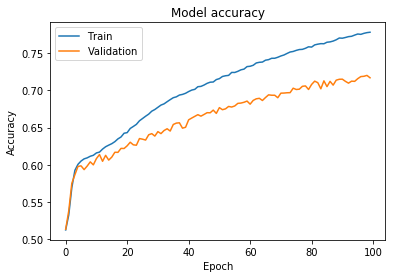

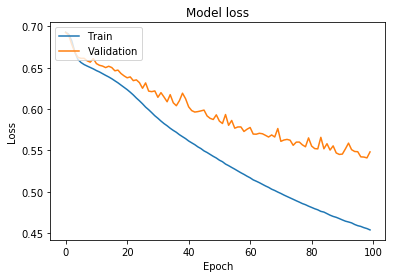

In [10]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Save the model as a .h5 file.

In [13]:
model.save('my_model.h5')

### Question 2 - (10 points)
#### Understanding what your model has learned

CNNs are often described as black boxes however that is not necessarily the case. Various methods have been developed which open up the black box. In class we looked at using the activation values from the convolutional filters and interpreting them as feature learners. In this question you will be using backpropagation methods, also referred to as saliency maps, to peer inside the box.

Begin by installing deeplift with your package manager (i.e. pip install deeplift). Import the module. Please see [deeplift](https://github.com/kundajelab/deeplift) for additional instructions and the [paper](https://arxiv.org/abs/1704.02685) for details on the algorithm.

In [14]:
import deeplift
from deeplift.conversion import kerasapi_conversion as kc

Load the model saved in Question 1. Use the `kc.convert_model_from_saved_files` function to convert the model into the necessary format for deeplift and use default options provided in lab (`nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault`).

In [15]:
deeplift_model =\
    kc.convert_model_from_saved_files(
        'my_model.h5',
        nonlinear_mxts_mode=deeplift.layers.NonlinearMxtsMode.DeepLIFT_GenomicsDefault) 

nonlinear_mxts_mode is set to: DeepLIFT_GenomicsDefault
For layer 0 the preceding linear layer is preact_0 of type Conv2D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 2 the preceding linear layer is preact_2 of type Conv2D;
In accordance with nonlinear_mxts_mode=DeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to Rescale
Heads-up: current implementation assumes maxpool layer is followed by a linear transformation (conv/dense layer)
For layer 5 the preceding linear layer is preact_5 of type Dense;
In accordance with nonlinear_mxts_modeDeepLIFT_GenomicsDefault we are setting the NonlinearMxtsMode to RevealCancel
Heads-up: I assume sigmoid is the output layer, not an intermediate one; if it's an intermediate layer then please bug me and I will implement the grad func
For layer 6 the prece

Print the layers of your model using the `.get_layers()` method.

In [16]:
deeplift_model.get_layers()

Using the output from the previous question, determine the index for the input layer. This will be the layer you would like to view the importance scores for. In this homework please choose the input layer but in your own research any layer may be used so feel free to experiment with others! 

Also determine the index for the pre-activation output layer. Hint: This will almost surely be a dense layer. In python you may index to the last item in a list by indexing with -1. How would you get to the second to last item? 

In [17]:
find_scores_layer_idx = 0
output_scores_layer_idx = -2

Now use the `get_target_contribs_func` method to calculate the contribution function for your input and output layers. This uses the model architecture of your CNN to define a function which may be used to calculate the importance scores for given observations and tasks (output channels). 

In [18]:
deeplift_contribs_func = deeplift_model.get_target_contribs_func(
                            find_scores_layer_idx=find_scores_layer_idx,
                            target_layer_idx=output_scores_layer_idx)

Define the output you would like to visualize importance scores for. Also, define a reference sequence based on genome background if desired.

In [19]:
output_class = 0
reference = np.array([.3,.2,.2,.3])[None,None,:]


Lastly, calculate the feature importance scores for a given `task_idx` (the output class). Specify your batch size and input data. Why is it important to use your testing data?

In [20]:
scores = np.array(deeplift_contribs_func(task_idx=output_class,
                                         input_data_list=[test['inputs']],
                                         batch_size=100,
                                         progress_update=1000,
                                        input_references_list=[reference]))

Done 0
Done 1000
Done 2000
Done 3000
Done 4000


And finally, visualize the importance scores for a given sequence. Make sure the sequence you visualize contains the motif corresponding to the `task_idx` you specified above. What do you notice about what your model has learned?

In [21]:
#visualize scores
%matplotlib inline
from deeplift.visualization import viz_sequence
idxs = np.argwhere(test['targets'][:,output_class]==1)
idx = idxs[1]

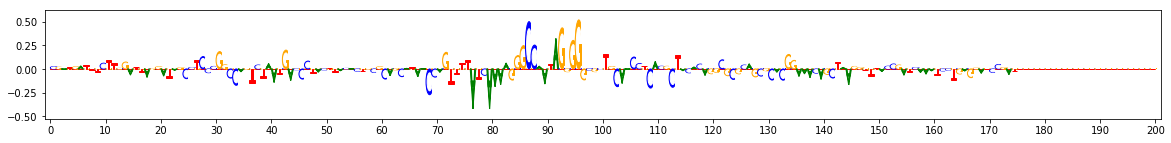

In [22]:
scores_for_idx = scores[idx,:,0,:]
original_onehot = test['inputs'][idx,:,0,:]
scores_for_idx = original_onehot*scores_for_idx
viz_sequence.plot_weights(scores_for_idx, subticks_frequency=10)